Training with batch_size=None, lr=0.001, alpha=0.001
Training with batch_size=None, lr=0.001, alpha=0.01
Training with batch_size=None, lr=0.001, alpha=0.1
Training with batch_size=None, lr=0.001, alpha=1.0
Training with batch_size=None, lr=0.005, alpha=0.001
Training with batch_size=None, lr=0.005, alpha=0.01
Training with batch_size=None, lr=0.005, alpha=0.1
Training with batch_size=None, lr=0.005, alpha=1.0
Training with batch_size=None, lr=0.01, alpha=0.001
Training with batch_size=None, lr=0.01, alpha=0.01
Training with batch_size=None, lr=0.01, alpha=0.1
Training with batch_size=None, lr=0.01, alpha=1.0
Training with batch_size=None, lr=0.015, alpha=0.001
Training with batch_size=None, lr=0.015, alpha=0.01
Training with batch_size=None, lr=0.015, alpha=0.1
Training with batch_size=None, lr=0.015, alpha=1.0
Training with batch_size=None, lr=0.02, alpha=0.001
Training with batch_size=None, lr=0.02, alpha=0.01
Training with batch_size=None, lr=0.02, alpha=0.1
Training with batch_siz

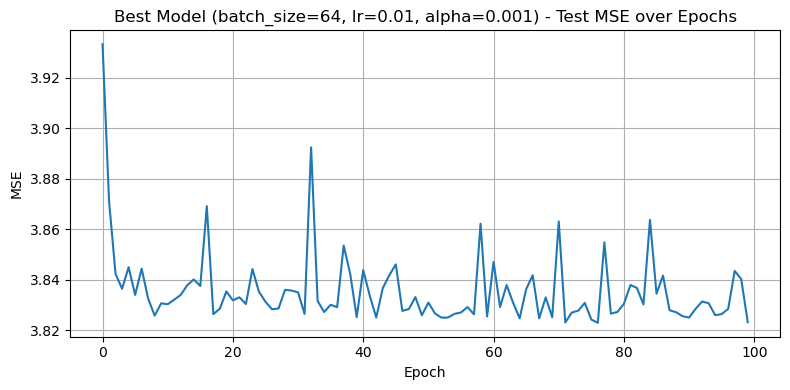


Top 5 performing combinations:
    batch_size     lr  alpha       mse        r2     rmsle
88        64.0  0.010  0.001  3.823186  0.598138  0.158803
92        64.0  0.015  0.001  3.823747  0.598079  0.159447
60        32.0  0.001  0.001  3.824248  0.598027  0.159029
40        16.0  0.001  0.001  3.825821  0.597861  0.158681
80        64.0  0.001  0.001  3.825837  0.597860  0.159176


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt
import itertools

def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / df["Shell weight"],
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / df["Shell weight"],
        "f03_Diameter_div_ShellWeight": df["Diameter"] / df["Shell weight"],
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual


df = pd.read_csv('train_cleaned_sex_binary.csv')
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors="ignore")
X_manual = manual_openfe_features(X_raw)
X = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X = X.drop(columns=["Length", "Whole weight"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)


def train_gd(X_tr, y_tr, X_te, y_te, lr, epochs, batch_size=None, alpha=0.01):
    n_samples, n_features = X_tr.shape
    w = np.zeros(n_features)
    b = 0.0
    history = {'test_mse': [], 'test_r2': [], 'test_rmsle': []}
    
    for epoch in range(epochs):
        if batch_size:
            idx = np.random.permutation(n_samples)
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                xb = X_tr[idx[start:end]]
                yb = y_tr[idx[start:end]]
                preds = xb.dot(w) + b
                err = preds - yb
                grad_w = (2/len(yb)) * xb.T.dot(err) + 2 * alpha * w
                grad_b = (2/len(yb)) * err.sum()
                w -= lr * grad_w
                b -= lr * grad_b
        else:
            preds = X_tr.dot(w) + b
            err = preds - y_tr
            grad_w = (2/n_samples) * X_tr.T.dot(err) + 2 * alpha * w
            grad_b = (2/n_samples) * err.sum()
            w -= lr * grad_w
            b -= lr * grad_b
        
        y_pred = X_te.dot(w) + b
        history['test_mse'].append(mean_squared_error(y_te, y_pred))
        history['test_r2'].append(r2_score(y_te, y_pred))
        y_te_clip   = np.maximum(y_te,   0)
        y_pred_clip = np.maximum(y_pred, 0)
        history['test_rmsle'].append(np.sqrt(mean_squared_log_error(y_te_clip, y_pred_clip)))
    
    final_y_pred = X_te.dot(w) + b
    final_mse    = mean_squared_error(y_te, final_y_pred)
    final_r2     = r2_score(y_te, final_y_pred)
    final_msle   = mean_squared_log_error(np.maximum(y_te, 0), np.maximum(final_y_pred, 0))
    final_rmsle  = np.sqrt(final_msle)

    return w, b, history, final_mse, final_r2, final_rmsle


df = pd.read_csv('train_cleaned_sex_binary.csv')
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors="ignore")
X_manual = manual_openfe_features(X_raw)
X = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X = X.drop(columns=["Length", "Whole weight"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# Define the parameter grid for grid search
param_grid = {
    'batch_size': [None, 1, 16, 32, 64],
    'lr': [0.001, 0.005, 0.01, 0.015, 0.02],
    'alpha': [0.001, 0.01, 0.1, 1.0]
}

# Perform grid search
results = []
epochs = 100

for batch_size, lr, alpha in itertools.product(param_grid['batch_size'], param_grid['lr'], param_grid['alpha']):
    print(f"Training with batch_size={batch_size}, lr={lr}, alpha={alpha}")
    w, b, hist, final_mse, final_r2, final_rmsle = train_gd(
        X_train_std, y_train.values,
        X_test_std, y_test.values,
        lr=lr, epochs=epochs, batch_size=batch_size, alpha=alpha
    )
    results.append({
        'batch_size': batch_size,
        'lr': lr,
        'alpha': alpha,
        'mse': final_mse,
        'r2': final_r2,
        'rmsle': final_rmsle,
        'history': hist
    })

# Find the best model based on test MSE
best_result = min(results, key=lambda x: x['mse'])

# Display the best model's performance
print(f"\nBest parameters: batch_size={best_result['batch_size']}, lr={best_result['lr']}, alpha={best_result['alpha']}")
print(f"Best MSE: {best_result['mse']:.4f}, R²: {best_result['r2']:.4f}, RMSLE: {best_result['rmsle']:.4f}")

# Plot the test MSE over epochs for the best model
plt.figure(figsize=(8, 4))
plt.plot(best_result['history']['test_mse'])
plt.title(f"Best Model (batch_size={best_result['batch_size']}, lr={best_result['lr']}, alpha={best_result['alpha']}) - Test MSE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.savefig('best_model_parameter_tuning.png', dpi=300)

plt.show()

# Optionally, display top 5 performing combinations
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mse')
print("\nTop 5 performing combinations:")
print(results_df[['batch_size', 'lr', 'alpha', 'mse', 'r2', 'rmsle']].head(5))

Final model (batch_size=32, lr=0.0008, alpha=0.001):
  Test MSE   = 3.8224
  Test R²    = 0.5982
  Test RMSLE = 0.1589


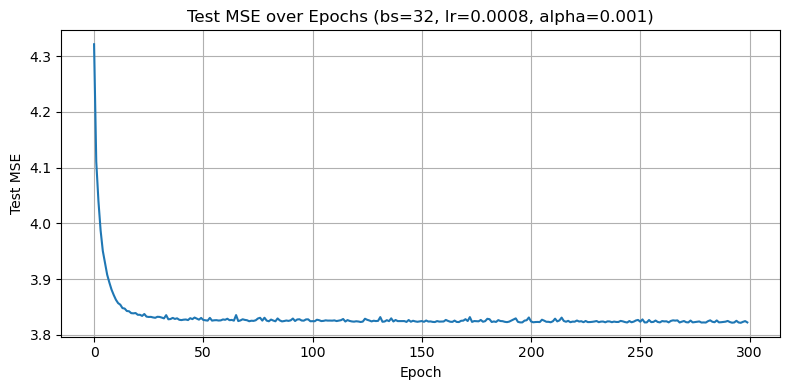

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt

def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / df["Shell weight"],
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / df["Shell weight"],
        "f03_Diameter_div_ShellWeight": df["Diameter"] / df["Shell weight"],
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual

# 1. Load and prepare data
df = pd.read_csv('train_cleaned_sex_binary.csv')
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors="ignore")
X_manual = manual_openfe_features(X_raw)
X = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X = X.drop(columns=["Length", "Whole weight"], errors="ignore")

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)

# 3. Standardize features
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 4. Gradient Descent with L2 penalty
def train_gd(X_tr, y_tr, X_te, y_te, lr, epochs, batch_size=None, alpha=0.01):
    n_samples, n_features = X_tr.shape
    w = np.zeros(n_features)
    b = 0.0
    history = {'test_mse': [], 'test_r2': [], 'test_rmsle': []}

    best_mse = np.inf
    no_improve = 0
    patience = 10
    
    for epoch in range(epochs):
        # update step
        if batch_size:
            idx = np.random.permutation(n_samples)
            for start in range(0, n_samples, batch_size):
                xb = X_tr[idx[start:start+batch_size]]
                yb = y_tr[idx[start:start+batch_size]]
                preds = xb.dot(w) + b
                err = preds - yb
                grad_w = (2/len(yb)) * xb.T.dot(err) + 2 * alpha * w
                grad_b = (2/len(yb)) * err.sum()
                w -= lr * grad_w
                b -= lr * grad_b
        else:
            preds = X_tr.dot(w) + b
            err = preds - y_tr
            grad_w = (2/n_samples) * X_tr.T.dot(err) + 2 * alpha * w
            grad_b = (2/n_samples) * err.sum()
            w -= lr * grad_w
            b -= lr * grad_b
        
        # record metrics
        y_pred = X_te.dot(w) + b
        history['test_mse'].append(mean_squared_error(y_te, y_pred))
        history['test_r2'].append(r2_score(y_te, y_pred))
        y_te_clip   = np.maximum(y_te,   0)
        y_pred_clip = np.maximum(y_pred, 0)
        history['test_rmsle'].append(np.sqrt(mean_squared_log_error(y_te_clip, y_pred_clip)))
    
    # final metrics
    final_y_pred = X_te.dot(w) + b
    final_mse    = mean_squared_error(y_te, final_y_pred)
    final_r2     = r2_score(y_te, final_y_pred)
    final_msle   = mean_squared_log_error(np.maximum(y_te, 0), np.maximum(final_y_pred, 0))
    final_rmsle  = np.sqrt(final_msle)

    return w, b, history, final_mse, final_r2, final_rmsle

# 5. Train and evaluate with best parameters
best_batch_size = 32
best_lr         = 0.0008
best_alpha      = 0.001
best_epochs     = 300

w_best, b_best, hist_best, mse_best, r2_best, rmsle_best = train_gd(
    X_train_std, y_train,
    X_test_std,  y_test,
    lr=best_lr,
    epochs=best_epochs,
    batch_size=best_batch_size,
    alpha=best_alpha
)

# 6. Display final performance
print(f"Final model (batch_size={best_batch_size}, lr={best_lr}, alpha={best_alpha}):")
print(f"  Test MSE   = {mse_best:.4f}")
print(f"  Test R²    = {r2_best:.4f}")
print(f"  Test RMSLE = {rmsle_best:.4f}")

# 7. Plot Test MSE over Epochs
plt.figure(figsize=(8,4))
plt.plot(hist_best['test_mse'])
plt.title(f"Test MSE over Epochs (bs={best_batch_size}, lr={best_lr}, alpha={best_alpha})")
plt.xlabel("Epoch")
plt.ylabel("Test MSE")
plt.grid(True)
plt.tight_layout()
plt.savefig('best_model_test_mse.png', dpi=300)
plt.show()

